<a href="https://colab.research.google.com/github/mhassanist/thesis-colab/blob/main/auto_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unrar x Depth.rar

In [ ]:
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import cv2
import struct
import os
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, MaxPooling2D, Flatten, Dense, Reshape, Lambda
from keras.models import load_model
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, LSTM, Dense, Conv2DTranspose
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix


In [ ]:
# Define the path to the dataset directory
dataset_path = "Depth/"
action_label_dict = {
    "a01": "High Arm Wave",
    "a02": "Horizontal Arm Wave",
    "a03": "Hammer",
    "a04": "Hand Catch",
    "a05": "Forward Punch",
    "a06": "High Throw",
    "a07": "Draw X",
    "a08": "Draw Tick",
    "a09": "Draw Circle",
    "a10": "Hand Clap",
    "a11": "Two Hand Wave",
    "a12": "Side-Boxing",
    "a13": "Bend",
    "a14": "Forward Kick",
    "a15": "Side Kick",
    "a16": "Jogging",
    "a17": "Tennis Swing",
    "a18": "Tennis Serve",
    "a19": "Golf Swing",
    "a20": "Pick Up and Throw"
}

action_label_dict = {
    "a01": 1,
    "a02": 2,
    "a03": 3,
    "a04": 4,
    "a05": 5,
    "a06": 6,
    "a07": 7,
    "a08": 8,
    "a09": 9,
    "a10": 10,
    "a11": 11,
    "a12": 12,
    "a13": 13,
    "a14": 14,
    "a15": 15,
    "a16": 16,
    "a17": 17,
    "a18": 18,
    "a19": 19,
    "a20": 20
}
action_labels = {}
activity_labels = []

num_classes = 21

activity_samples = []

max_n_frames = 0
for filename in os.listdir(dataset_path)[:100]:
    if not filename.endswith("depth.bin"):
        continue

    action_label = filename.split("_")[0]
    activity_labels.append(action_label_dict[action_label])

    # Load the depth map data from the binary file
    with open(dataset_path + filename, "rb") as f:
        i,  = struct.unpack('i', f.read(4))  # frame count
        # print(f"Frame count is {i}")
        w,  = struct.unpack('i', f.read(4))  # width
        h,  = struct.unpack('i', f.read(4))  # height

        single_activity_list = []
        # read frame by frame
        for frame in range(i):
            bytesread = f.read(w*h*4)
            depth_data = np.frombuffer(bytesread, dtype=np.uint32)
            single_depth_img = depth_data.reshape((240, 320))


            # print(single_depth_img.shape)
            single_activity_list.append(single_depth_img)

        activity_samples.append(single_activity_list)


Loading dataset...


In [ ]:
image_sample = activity_samples[3][15]

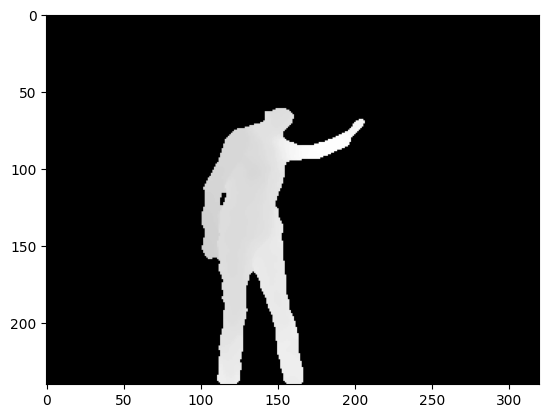

In [ ]:
plt.imshow(image_sample, cmap='gray')


In [ ]:
from skimage.transform import resize
from keras.optimizers import Adam

single_depth_img = image_sample
resized_depth_img = resize(single_depth_img, (64, 64), anti_aliasing=True)

normalized_depth_img = resized_depth_img.astype('float32') / 255.0

reshaped_depth_img = normalized_depth_img.reshape((1, 64, 64, 1))


# Input layer
# Grayscale image (1 channel)
encoder_input = Input(shape=(64, 64, 1))
encoder_flattened = Flatten()(encoder_input)
encoder_output = Dense(256, activation='relu')(encoder_flattened)

encoder = Model(encoder_input, encoder_output, name = "encoder")

decoder_input = Dense(4096, activation='relu')(encoder_output)
decoder_output = Reshape((64,64,1))(decoder_input)

opt = Adam(lr=0.001, decay = 1e-6)

autoencoder = Model(encoder_input, decoder_output, name = "autoencoder")

#autoencoder.summary()
autoencoder.compile(opt, loss='mse')
autoencoder.fit(reshaped_depth_img, reshaped_depth_img, epochs=10, batch_size=32 )


mse = autoencoder.evaluate(
                reshaped_depth_img, reshaped_depth_img, verbose=0)

print("Mean Squared Error (MSE):", mse)


Epoch 1/10
1/1 [==============================] - 0s 393ms/step - loss: 1.4831e-20
Epoch 2/10
1/1 [==============================] - 0s 10ms/step - loss: 1.2744e-20
Epoch 3/10
1/1 [==============================] - 0s 9ms/step - loss: 1.0548e-20
Epoch 4/10
1/1 [==============================] - 0s 9ms/step - loss: 8.8269e-21
Epoch 5/10
1/1 [==============================] - 0s 11ms/step - loss: 7.7279e-21
Epoch 6/10
1/1 [==============================] - 0s 9ms/step - loss: 7.2284e-21
Epoch 7/10
1/1 [==============================] - 0s 10ms/step - loss: 7.1647e-21
Epoch 8/10
1/1 [==============================] - 0s 12ms/step - loss: 7.3160e-21
Epoch 9/10
1/1 [==============================] - 0s 11ms/step - loss: 7.4971e-21
Epoch 10/10
1/1 [==============================] - 0s 11ms/step - loss: 7.5699e-21
Mean Squared Error (MSE): 7.45868758339065e-21


In [ ]:
example = encoder.predict(reshaped_depth_img)
print(example.shape)

1/1 [==============================] - 0s 57ms/step
(1, 256)


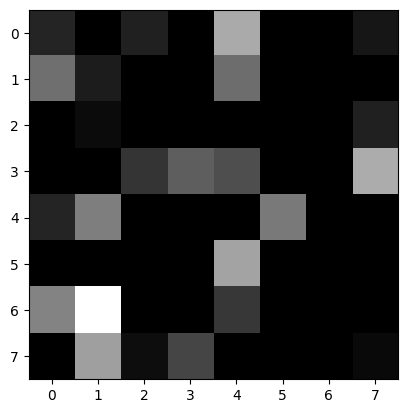

In [ ]:
plt.imshow(example.reshape(16,8), cmap="gray")

In [ ]:
ae_out = autoencoder.predict(reshaped_depth_img.reshape(-1,64,64,1))[0]

1/1 [==============================] - 0s 73ms/step


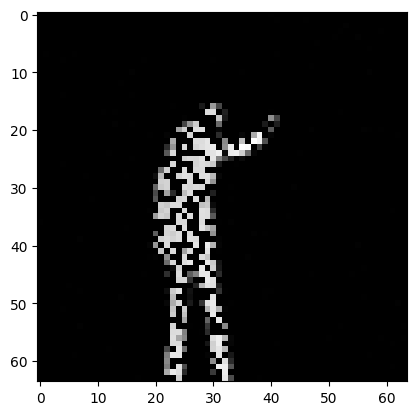

In [ ]:
plt.imshow(ae_out, cmap="gray")

In [ ]:
activities = activity_samples
labels = activity_labels

# Preprocess frames
def preprocess_frame(frame):
    resized_frame = resize(frame, (224, 224))
    normalized_frame = resized_frame / 255.0  # Normalize pixel values
    return normalized_frame

# Calculate FDN
def calculate_fdn(frames):
    differences = [np.mean(np.abs(frame1 - frame2)) for frame1, frame2 in zip(frames[:-1], frames[1:])]
    return differences

# Prepare data for training
X_fmkn = []
X_fdn = []
y_labels = []

for i, activity_frames in enumerate(activities):
    spatial_feature_maps = []
    fdn_values = []

    for frame_list in activity_frames:
        preprocessed_frames = [preprocess_frame(frame) for frame in frame_list]
        spatial_feature_maps.append(preprocessed_frames)
        fdn_values.extend(calculate_fdn(preprocessed_frames))

    X_fmkn.append(spatial_feature_maps)
    X_fdn.append(fdn_values)
    y_labels.append(labels[i])  # Activity label for this batch

X_fmkn = np.array(X_fmkn)
X_fdn = np.array(X_fdn)
y_labels = np.array(y_labels)

y_one_hot = to_categorical(y_labels, num_classes)

N = 10
K = 32
# Train the model
# Build the model
def build_har_model():
    # CNN function to extract spatial features
    def cnn_layers(input_shape):
        model = tf.keras.Sequential()
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
        # Add more convolutional layers as needed
        return model

    # Function to calculate weighted mean
    def weighted_mean(x):
        fmkn, fdn = x[0], x[1]
        return tf.reduce_sum(tf.multiply(fmkn, fdn), axis=0) / tf.reduce_sum(fdn)

    # Input for spatial feature map
    input_fmkn = Input(shape=(N, K))

    # Input for temporal feature (frame change rate)
    input_fdn = Input(shape=(N - 1,))

    # Extract spatial features using CNN
    cnn_output = cnn_layers((224, 224, 3))(input_fmkn)

    # Calculate spatiotemporal features using weighted mean
    spatiotemporal_features = Lambda(weighted_mean)([cnn_output, input_fdn])

    # Create MLP for action classification
    mlp_input = Flatten()(spatiotemporal_features)
    mlp_output = Dense(num_classes, activation='softmax')(mlp_input)

    # Create the final model
    model = Model(inputs=[input_fmkn, input_fdn], outputs=mlp_output)
    return model

# Prepare data for training as before

# Build the model
har_model = build_har_model()

# Compile the model
har_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
har_model.fit([X_fmkn, X_fdn], y_one_hot, epochs=10, batch_size=32)
